# Bitcoin - Buy or Sell?

## Load and Clean Data

In [1]:
import numpy as np
import pandas as pd
import scipy
import datetime as datetime
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import residuals_plot
import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import fbprophet
import math
import pmdarima as pm

%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
# Load data
bitcoin = pd.read_csv('yahoo_BTC-USD_d_train.csv')

cpi = pd.read_csv('yahoo_CPI_d.csv')
dow = pd.read_csv('yahoo_DJI_d.csv')
sp = pd.read_csv('yahoo_SP500_d.csv')
usd = pd.read_csv('yahoo_USD_d.csv')
vix = pd.read_csv('yahoo_VIX_d.csv')
interest = pd.read_csv('fed_interest_rates_us.csv')
trend = pd.read_csv('trend_bitcoin.csv')
unemploy = pd.read_csv('fed_bls_unemployment_us.csv')

actual = pd.read_csv('yahoo_BTC-USD_d_test.csv')

In [3]:
# Add time series 'date' column to actual data frame
actual['date'] = pd.to_datetime(actual['Date'])

# Drop unwanted columns
actual.drop(['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

# Rename column
actual.rename(columns={'Close': 'actual_close'}, inplace=True)

# Drop missing values
actual.dropna(inplace=True)

# Check data frame
actual

,actual_close,date
0,7200.174316,2020-01-01
1,6985.470215,2020-01-02
2,7344.884277,2020-01-03
3,7410.656738,2020-01-04
4,7411.317383,2020-01-05
...,...,...
96,7271.781250,2020-04-06
97,7176.414551,2020-04-07
98,7334.098633,2020-04-08
99,7302.089355,2020-04-09


In [4]:
# Add time series 'date' column to unemployment data frame
unemploy['date'] = pd.date_range(start='2014-01-01', end='2020-03-01', normalize=True, freq='MS')

# Drop unwanted column
unemploy.drop(['Series ID', 'Year', 'Period'], axis=1, inplace=True)

# Rename column
unemploy.rename(columns={'Value': 'unemploy'}, inplace=True)

# Check data frame
unemploy.head()

,unemploy,date
0,6.6,2014-01-01
1,6.7,2014-02-01
2,6.7,2014-03-01
3,6.2,2014-04-01
4,6.3,2014-05-01


In [5]:
# Add time series 'date' column to trend data frame
trend['date'] = pd.to_datetime(trend['Month'])

# Drop unwanted column
trend.drop('Month', axis=1, inplace=True)

# Rename column
trend.rename(columns={'bitcoin: (Worldwide)': 'trend'}, inplace=True)

# Check data frame
trend.head()

,trend,date
0,3,2014-12-01
1,3,2015-01-01
2,3,2015-02-01
3,3,2015-03-01
4,2,2015-04-01


In [6]:
# Add time series 'date' column to interest data frame
interest['date'] = pd.to_datetime(interest['Series Description'])

# Drop unwanted columns
col_to_drop = interest.columns.to_list()
col_to_drop.remove('Market yield on U.S. Treasury securities at 1-month   constant maturity, quoted on investment basis')
col_to_drop.remove('date')

interest.drop(col_to_drop, axis=1, inplace=True)

# Rename column to interest
interest.rename(columns={'Market yield on U.S. Treasury securities at 1-month   constant maturity, quoted on investment basis': 'interest'}, inplace=True)

# Make interest data numeric
interest['interest'] = pd.to_numeric(interest['interest'], errors='coerce')

# Check data frame
interest.head()

,interest,date
0,0.01,2014-12-01
1,0.04,2014-12-02
2,0.03,2014-12-03
3,0.03,2014-12-04
4,0.02,2014-12-05


In [7]:
# Rename 'Date' column to 'date' and clarify 'Close' column
bitcoin.rename(columns={'Date': 'date', 'Close': 'bitcoin_close'}, inplace=True)
cpi.rename(columns={'Date': 'date', 'Close': 'cpi_close'}, inplace=True)
dow.rename(columns={'Date': 'date', 'Close': 'dow_close'}, inplace=True)
sp.rename(columns={'Date': 'date', 'Close': 'sp_close'}, inplace=True)
usd.rename(columns={'Date': 'date', 'Close': 'usd_close'}, inplace=True)
vix.rename(columns={'Date': 'date', 'Close': 'vix_close'}, inplace=True)

# Change 'date' column from object to datetime
bitcoin['date'] = pd.to_datetime(bitcoin['date'])
cpi['date'] = pd.to_datetime(cpi['date'])
dow['date'] = pd.to_datetime(dow['date'])
sp['date'] = pd.to_datetime(sp['date'])
usd['date'] = pd.to_datetime(usd['date'])
vix['date'] = pd.to_datetime(vix['date'])

# Drop unwanted columns
col_to_drop = ['Open', 'High', 'Low', 'Adj Close', 'Volume']

bitcoin.drop(col_to_drop, axis=1, inplace=True)
cpi.drop(col_to_drop, axis=1, inplace=True)
dow.drop(col_to_drop, axis=1, inplace=True)
sp.drop(col_to_drop, axis=1, inplace=True)
usd.drop(col_to_drop, axis=1, inplace=True)
vix.drop(col_to_drop, axis=1, inplace=True)

In [8]:
# Check data frames
bitcoin.head()

,date,bitcoin_close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


In [9]:
cpi.head()

,date,cpi_close
0,2014-12-01,26.660000
1,2014-12-02,26.690001
2,2014-12-03,26.750000
3,2014-12-04,26.670000
4,2014-12-05,26.680000


In [10]:
dow.head()

,date,dow_close
0,2014-12-01,17776.800781
1,2014-12-02,17879.550781
2,2014-12-03,17912.619141
3,2014-12-04,17900.099609
4,2014-12-05,17958.789063


In [11]:
sp.head()

,date,sp_close
0,2014-12-01,2053.439941
1,2014-12-02,2066.550049
2,2014-12-03,2074.330078
3,2014-12-04,2071.919922
4,2014-12-05,2075.370117


In [12]:
usd.head()

,date,usd_close
0,2014-12-01,87.949997
1,2014-12-02,88.650002
2,2014-12-03,88.959999
3,2014-12-04,88.699997
4,2014-12-05,89.330002


In [13]:
vix.head()

,date,vix_close
0,2014-12-01,14.16
1,2014-12-02,12.85
2,2014-12-03,12.50
3,2014-12-04,12.38
4,2014-12-05,11.89


In [14]:
# Make new data frame to collect variables of interest
final = bitcoin[['date', 'bitcoin_close']].copy()
final.head()

,date,bitcoin_close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


In [15]:
# Merge all data frames into one
final = final.merge(cpi[['date','cpi_close']], how='inner', left_on='date', right_on='date')
final = final.merge(dow[['date','dow_close']], how='inner', left_on='date', right_on='date')
final = final.merge(sp[['date','sp_close']], how='inner', left_on='date', right_on='date')
final = final.merge(usd[['date','usd_close']], how='inner', left_on='date', right_on='date')
final = final.merge(vix[['date','vix_close']], how='inner', left_on='date', right_on='date')
final = final.merge(interest[['date','interest']], how='inner', left_on='date', right_on='date')
final = final.merge(trend[['date','trend']], how='left', left_on='date', right_on='date')
final = final.merge(unemploy[['date','unemploy']], how='left', left_on='date', right_on='date')

# Check data types
final.dtypes

date             datetime64[ns]
bitcoin_close           float64
cpi_close               float64
dow_close               float64
sp_close                float64
usd_close               float64
vix_close               float64
interest                float64
trend                   float64
unemploy                float64
dtype: object

In [16]:
# Use forward fill to fill in missing trend values
final['trend'].ffill(inplace=True)

# Use forward fill to fill in missing unemploy values
final['unemploy'].ffill(inplace=True)

In [17]:
# Check final data frame
final

,date,bitcoin_close,cpi_close,dow_close,sp_close,usd_close,vix_close,interest,trend,unemploy
0,2014-12-01,379.244995,26.660000,17776.800781,2053.439941,87.949997,14.16,0.01,3.0,5.6
1,2014-12-02,381.315002,26.690001,17879.550781,2066.550049,88.650002,12.85,0.04,3.0,5.6
2,2014-12-03,375.010010,26.750000,17912.619141,2074.330078,88.959999,12.50,0.03,3.0,5.6
3,2014-12-04,369.604004,26.670000,17900.099609,2071.919922,88.699997,12.38,0.03,3.0,5.6
4,2014-12-05,376.854004,26.680000,17958.789063,2075.370117,89.330002,11.89,0.02,3.0,5.6
...,...,...,...,...,...,...,...,...,...,...
1273,2019-12-24,7322.532227,28.469999,28515.449219,3223.379883,NaN,12.67,1.55,11.0,3.5
1274,2019-12-26,7238.966797,28.490000,28621.390625,3239.909912,97.589996,12.65,1.59,11.0,3.5
1275,2019-12-27,7290.088379,28.520000,28645.259766,3240.020020,96.919998,13.43,1.56,11.0,3.5
1276,2019-12-30,7292.995117,27.879999,28462.140625,3221.290039,96.739998,14.82,1.51,11.0,3.5


In [18]:
# Check for any remaining missing values
final.isnull().sum()

date             0
bitcoin_close    0
cpi_close        0
dow_close        0
sp_close         0
usd_close        9
vix_close        0
interest         7
trend            0
unemploy         0
dtype: int64

In [19]:
# Drop missing values (very small percentage of the data)
final.dropna(inplace=True)

# Reset index
final.reset_index(inplace=True, drop=True)

# Check final data frame
final

,date,bitcoin_close,cpi_close,dow_close,sp_close,usd_close,vix_close,interest,trend,unemploy
0,2014-12-01,379.244995,26.660000,17776.800781,2053.439941,87.949997,14.16,0.01,3.0,5.6
1,2014-12-02,381.315002,26.690001,17879.550781,2066.550049,88.650002,12.85,0.04,3.0,5.6
2,2014-12-03,375.010010,26.750000,17912.619141,2074.330078,88.959999,12.50,0.03,3.0,5.6
3,2014-12-04,369.604004,26.670000,17900.099609,2071.919922,88.699997,12.38,0.03,3.0,5.6
4,2014-12-05,376.854004,26.680000,17958.789063,2075.370117,89.330002,11.89,0.02,3.0,5.6
...,...,...,...,...,...,...,...,...,...,...
1257,2019-12-23,7355.628418,28.450001,28551.529297,3224.010010,97.680000,12.61,1.57,11.0,3.5
1258,2019-12-26,7238.966797,28.490000,28621.390625,3239.909912,97.589996,12.65,1.59,11.0,3.5
1259,2019-12-27,7290.088379,28.520000,28645.259766,3240.020020,96.919998,13.43,1.56,11.0,3.5
1260,2019-12-30,7292.995117,27.879999,28462.140625,3221.290039,96.739998,14.82,1.51,11.0,3.5


## Explore Data

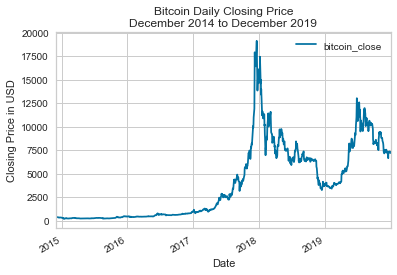

In [20]:
# Plot bitcoin time series
final.plot(x='date', y='bitcoin_close')
plt.title('Bitcoin Daily Closing Price\nDecember 2014 to December 2019')
plt.xlabel('Date')
plt.ylabel('Closing Price in USD')
plt.show()

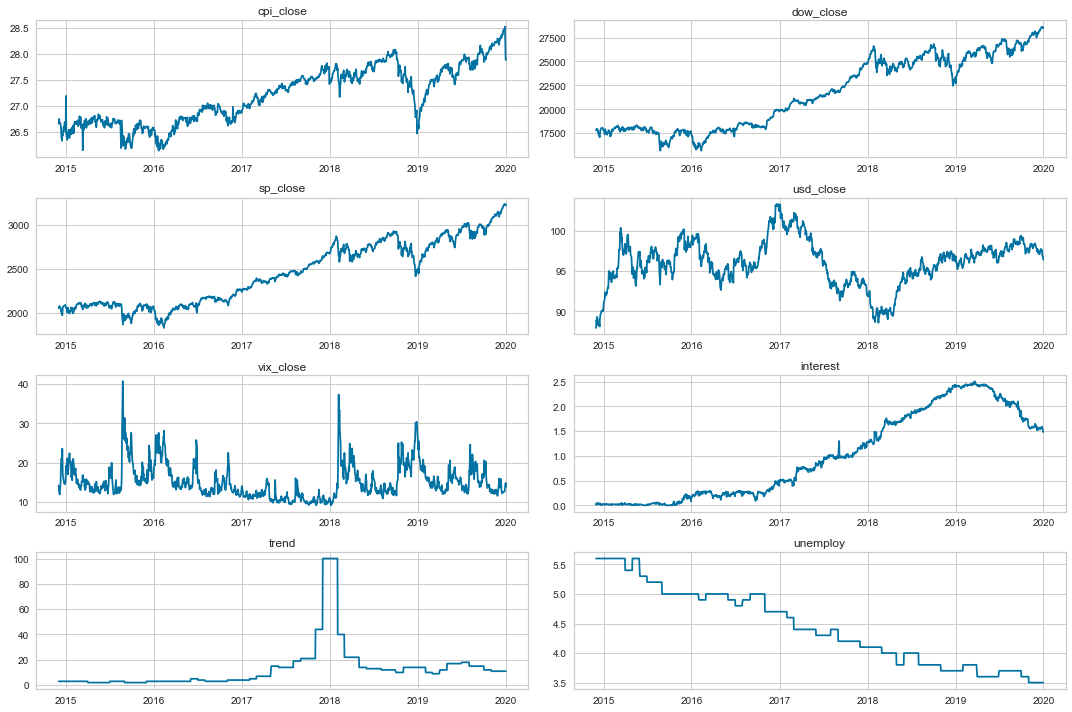

In [21]:
# Plot 8 variables
column_list = ['cpi_close', 'dow_close', 'sp_close', 'usd_close',
               'vix_close', 'interest', 'trend', 'unemploy']

plt.figure(figsize=(15, 10))

for i, col in enumerate(column_list):
    plt.subplot(4, 2, i + 1)
    plt.plot(final['date'], final[col])
    plt.title(col)

# Show plots
plt.tight_layout()
plt.show()

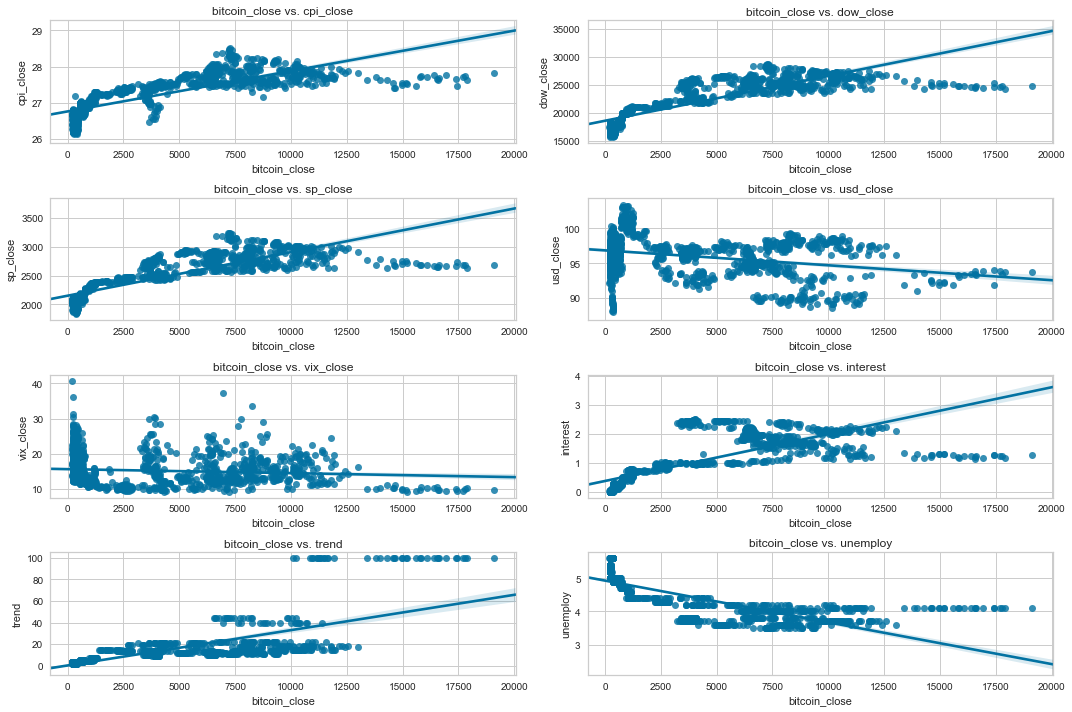

In [22]:
# Plot bitcoin vs. 8 variables
column_list = ['cpi_close', 'dow_close', 'sp_close', 'usd_close',
               'vix_close', 'interest', 'trend', 'unemploy']

plt.figure(figsize=(15, 10))

for i, col in enumerate(column_list):
    plt.subplot(4, 2, i + 1)
    sns.regplot(x=final['bitcoin_close'], y=final[col])
    plt.title('bitcoin_close vs. ' + col)
    plt.xlabel('bitcoin_close')
    plt.ylabel(col)

# Show plots
plt.tight_layout()
plt.show()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


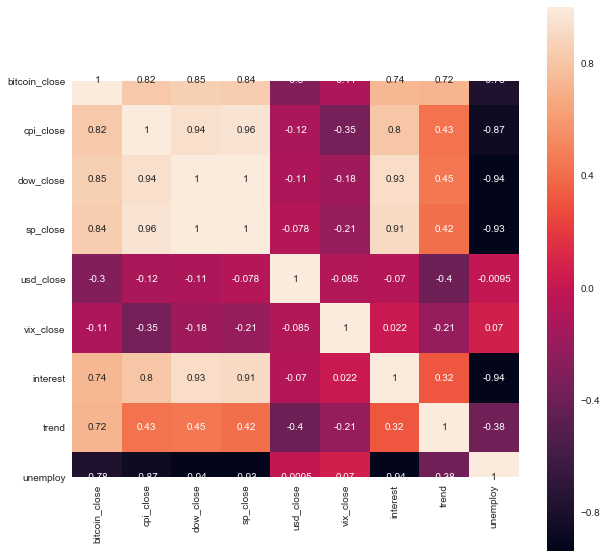

In [23]:
# Look at correlation matrix as heat meap
corr_mat = final.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_mat, annot=True, square=True)

plt.show()

## Build and Evaluate Models

### Facebook Prophet Model

In [24]:
gm = final[['date', 'bitcoin_close']].copy()
gm.rename(columns={'date': 'ds', 'bitcoin_close': 'y'}, inplace=True)
gm.tail()

,ds,y
1257,2019-12-23,7355.628418
1258,2019-12-26,7238.966797
1259,2019-12-27,7290.088379
1260,2019-12-30,7292.995117
1261,2019-12-31,7193.599121


In [25]:
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.2, yearly_seasonality=True)
gm_prophet.fit(gm)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
gm_forecast = gm_prophet.make_future_dataframe(periods=90, freq='D')
gm_forecast = gm_prophet.predict(gm_forecast)

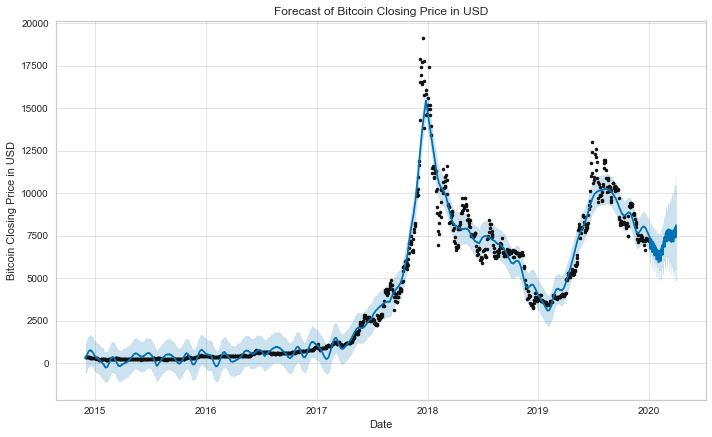

In [27]:
gm_prophet.plot(gm_forecast, xlabel='Date', ylabel='Bitcoin Closing Price in USD')
plt.title('Forecast of Bitcoin Closing Price in USD')
plt.show()

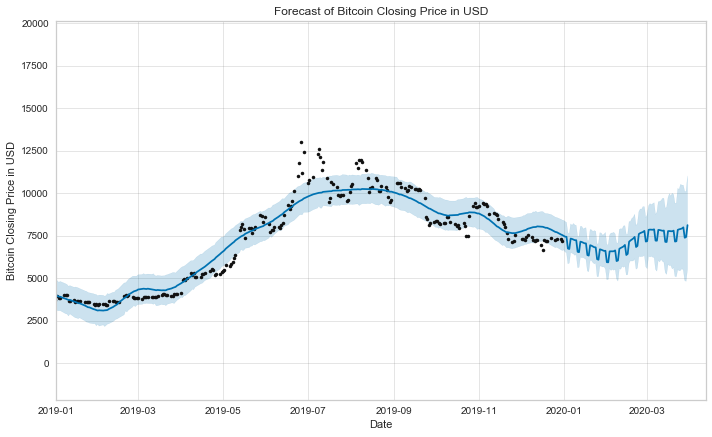

In [28]:
gm_prophet.plot(gm_forecast, xlabel='Date', ylabel='Bitcoin Closing Price in USD')
plt.xlim([datetime.date(2019, 1, 1)], [datetime.date(2020, 4, 12)])
plt.title('Forecast of Bitcoin Closing Price in USD')
plt.show()

If overfittting (too much flexibility), decrease changepoint prior scale. If underfitting (too little flexibility), increase changepoint prior scale.

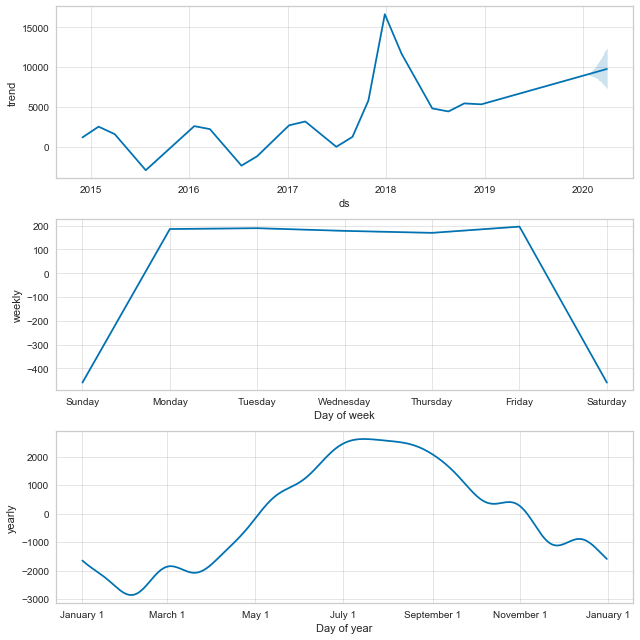

In [29]:
gm_prophet.plot_components(gm_forecast);

# What do these plots tell me? Can I change anything based on these plots to make my model better?

In [30]:
fbp = gm_forecast[['ds', 'yhat']][(gm_forecast['ds'] >= datetime.date(2020, 1, 1)) & (gm_forecast['ds'] < datetime.date(2020, 4, 13))]
fbp.rename(columns={'ds': 'date', 'yhat': 'fbp_forecast'}, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


In [31]:
actual = actual.merge(fbp, how='inner', left_on='date', right_on='date')
actual

,actual_close,date,fbp_forecast
0,7200.174316,2020-01-01,7491.324569
1,6985.470215,2020-01-02,7447.081397
2,7344.884277,2020-01-03,7439.084870
3,7410.656738,2020-01-04,6749.852761
4,7411.317383,2020-01-05,6719.003168
...,...,...,...
85,6716.440430,2020-03-26,7928.519463
86,6469.798340,2020-03-27,7995.008030
87,6242.193848,2020-03-28,7382.027573
88,5922.042969,2020-03-29,7428.896153


In [32]:
print('Facebook Prophet Performance')
print('\nRoot mean squared error: %.2f'
      % mean_squared_error(actual['actual_close'], actual['fbp_forecast']) ** 0.5)

print('\nMean absolute error: %.2f'
      % mean_absolute_error(actual['actual_close'], actual['fbp_forecast']))

Facebook Prophet Performance

Root mean squared error: 2131.68

Mean absolute error: 1894.42


# TO DO

In [33]:
gm_dow = final[['date', 'dow_close']].copy()
gm_dow.rename(columns={'date': 'ds', 'dow_close': 'y'}, inplace=True)
gm_dow_prophet = fbprophet.Prophet(changepoint_prior_scale=0.2, yearly_seasonality=True)
gm_dow_prophet.fit(gm_dow)
gm_dow_forecast = gm_dow_prophet.make_future_dataframe(periods=90, freq='D')
gm_dow_forecast = gm_dow_prophet.predict(gm_dow_forecast)

fbp_dow = gm_dow_forecast[['ds', 'yhat']][(gm_dow_forecast['ds'] >= datetime.date(2020, 1, 1)) & (gm_dow_forecast['ds'] < datetime.date(2020, 4, 13))]
fbp_dow.rename(columns={'ds': 'date', 'yhat': 'fbp_dow_forecast'}, inplace=True)
fbp_dow

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


,date,fbp_dow_forecast
1262,2020-01-01,28543.945061
1263,2020-01-02,28576.539369
1264,2020-01-03,28607.365755
1265,2020-01-04,28383.802982
1266,2020-01-05,28415.683235
...,...,...
1347,2020-03-26,30224.865731
1348,2020-03-27,30242.578246
1349,2020-03-28,30005.109388
1350,2020-03-29,30022.303882


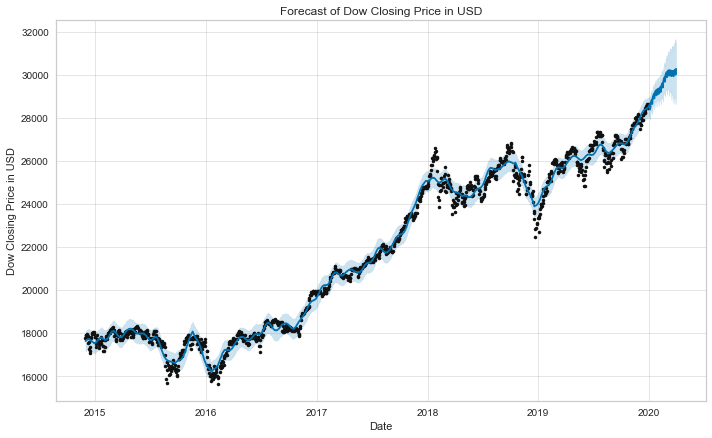

In [34]:
gm_dow_prophet.plot(gm_dow_forecast, xlabel='Date', ylabel='Dow Closing Price in USD')
plt.title('Forecast of Dow Closing Price in USD')
plt.show()

In [35]:
gm['dow_close'] = final['dow_close']
gm

,ds,y,dow_close
0,2014-12-01,379.244995,17776.800781
1,2014-12-02,381.315002,17879.550781
2,2014-12-03,375.010010,17912.619141
3,2014-12-04,369.604004,17900.099609
4,2014-12-05,376.854004,17958.789063
...,...,...,...
1257,2019-12-23,7355.628418,28551.529297
1258,2019-12-26,7238.966797,28621.390625
1259,2019-12-27,7290.088379,28645.259766
1260,2019-12-30,7292.995117,28462.140625


In [45]:
fbp_dow

,date,fbp_dow_forecast
1262,2020-01-01,28543.945061
1263,2020-01-02,28576.539369
1264,2020-01-03,28607.365755
1265,2020-01-04,28383.802982
1266,2020-01-05,28415.683235
...,...,...
1347,2020-03-26,30224.865731
1348,2020-03-27,30242.578246
1349,2020-03-28,30005.109388
1350,2020-03-29,30022.303882


In [46]:
def dow_price(ds):
    date = pd.to_datetime(ds)
    
    if date.year == 2020:
        return fbp_dow['fbp_dow_forecast'][fbp_dow['date'] == date]
    
    else:
        return gm['dow_close'][gm['date'] == date]
    
    return 0

In [47]:
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.2, yearly_seasonality=True)
gm_prophet.add_regressor('dow_close')
gm_prophet.fit(gm)

gm_forecast['dow_close'] = gm_forecast['ds'].apply(dow_price)
gm_forecast = gm_prophet.make_future_dataframe(periods=90, freq='D')
gm_forecast = gm_prophet.predict(gm_forecast)

# gm_prophet.plot(gm_forecast, xlabel='Date', ylabel='Bitcoin Closing Price in USD')
# plt.title('Forecast of Bitcoin Closing Price in USD\nwith Dow Regressor')
# plt.show()

# # fbp_dow = gm_forecast[['ds', 'yhat']][(gm_forecast['ds'] >= datetime.date(2020, 1, 1)) & (gm_forecast['ds'] < datetime.date(2020, 4, 13))]
# # fbp_dow.rename(columns={'ds': 'date', 'yhat': 'fbp_dow_forecast'}, inplace=True)
# # fbp_dow

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KeyError: 'date'

### ARIMA Model

In [ ]:
# Plot bitcoin time series
final.plot(x='date', y='bitcoin_close')
plt.title('Bitcoin Daily Closing Price\nDecember 2014 to December 2019')
plt.xlabel('Date')
plt.ylabel('Closing Price in USD')
plt.show()

In [ ]:
# Take first difference
diff = final[['date']].copy()
diff['diff_1'] = final.bitcoin_close - final.bitcoin_close.shift()

# Plot first difference to see if data set is stationary
diff.plot(x='date', y='diff_1')
plt.title('Bitcoin Daily Closing Price\nDecember 2014 to December 2019')
plt.xlabel('Date')
plt.ylabel('First Difference')
plt.show()

In [ ]:
# Use ACF to find most optimal MA(q) model
plot_acf(final.bitcoin_close, lags=50, alpha=0.05)
plt.title('Bitcoin ACF')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

Autocorrelations are significant for a large number of lags (50+).

In [ ]:
# Use PACF to find most optimal AR(p) model
plot_pacf(final.bitcoin_close, lags=50, alpha=0.05)
plt.title('Bitcoin Difference PACF')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

However, the PACF plot indicates that the autocorrelations seen in the ACF plot are largely due to the propagation of the autocorrelation at lag 1.

In [ ]:
# Use ACF to find most optimal MA(q) model
plot_acf(diff['diff_1'][1:], lags=50, alpha=0.05)
plt.title('Bitcoin Difference ACF')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

The ACF cuts off at lag 0, suggesting that an MA term is not needed for the differenced series.

In [ ]:
# Use PACF to find most optimal AR(p) model
plot_pacf(diff.diff_1[1:], lags=50, alpha=0.05)
plt.title('Bitcoin Difference PACF')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

The PACF cuts off at lag 0, suggesting that an AR term is not needed for the differenced series. Based on these analyses, I will first try an ARIMA(0, 1, 0) model.

In [ ]:
# Build ARIMA(0, 1, 0) model
model = ARIMA(final.bitcoin_close, order=(0, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
# Build ARIMA(1, 0, 0) model
model = ARIMA(final.bitcoin_close, order=(1, 0, 0))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
# Build ARIMA(1, 1, 0) model
model = ARIMA(final.bitcoin_close, order=(1, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
# Build ARIMA(0, 0, 1) model
model = ARIMA(final.bitcoin_close, order=(0, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
# Build ARIMA(0, 1, 1) model
model = ARIMA(final.bitcoin_close, order=(0, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
# Build ARIMA(1, 1, 1) model
model = ARIMA(final.bitcoin_close, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
stepwise_fit = pm.auto_arima(final.bitcoin_close,
                             start_p=1, max_p=3,
                             d=1,
                             start_q=1, max_q=3,
                             trace=True, # show individual results
                             seasonal=False, # don't want to correct for seasonality
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

In [ ]:
# Forecast using ARIMA(0, 1, 0) model
model = ARIMA(final.bitcoin_close, order=(0, 1, 0))
model_fit = model.fit()
actual['arima_forecast'] = model_fit.forecast(steps=90)[0]
actual

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
residuals['date'] = final['date'][1:]

residuals.plot(x='date', legend=False)
plt.xlabel('Date')
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

In [ ]:
print('ARIMA(0, 1, 0) Performance')
print('\nRoot mean squared error: %.2f'
      % mean_squared_error(actual['actual_close'], actual['arima_forecast']) ** 0.5)

print('\nMean absolute error: %.2f'
      % mean_absolute_error(actual['actual_close'], actual['arima_forecast']))

RMSE = in units of predictions, more weight on large errors
MAE = in units of predictions

### Ensemble Model: Linear Regression or Random Forest Regressor Plus ARIMA

#### Select Features Using PCA

In [ ]:
# Set feature and target variables
X = final[['cpi_close', 'dow_close', 'sp_close', 'usd_close', 'vix_close', 'interest', 'trend', 'unemploy']]
y = final['bitcoin_close']

# Standardize features
X = StandardScaler().fit_transform(X)

# Perform PCA
pca = PCA(n_components=8)
principal_components = pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component:\n',
    pca.explained_variance_ratio_,
    '\n\nThe cumulative percentage of total variance in the dataset explained by',
    'the components:\n',
    pca.explained_variance_ratio_.cumsum()
)

In [ ]:
# Print scree plot
Xt = X.T
Cx = np.cov(Xt)

eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

In [ ]:
# Use all 8 components as features in model
pca = PCA(n_components=8)
principal_components = pca.fit_transform(X)
X_pca = pd.DataFrame(data=principal_components)
X_pca

#### Linear Regression Model

In [ ]:
# Create training and testing sets from X_pca and y
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=1234)

In [ ]:
lrm = linear_model.LinearRegression()

lrm.fit(X_train, y_train)

y_pred = lrm.predict(X_test)

print('Coefficients:\n', lrm.coef_)

print('\nMean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

print('\nRoot mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred) ** 0.5)

print('\nR squared: %.2f'
      % r2_score(y_test, y_pred))

In [ ]:
sns.regplot(x=y_test, y=y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Bitcoin Closing Price:\nActual vs. Predicted')

plt.show()

In [ ]:
# Create the visualizer, fit, score, and show it
viz = residuals_plot(linear_model.LinearRegression(), X_train, y_train, X_test, y_test)

#### Random Forest Regressor

In [ ]:
rfr = RandomForestRegressor()

rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

In [ ]:
print('\nMean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

print('\nRoot mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred) ** 0.5)

print('\nR squared: %.2f'
      % r2_score(y_test, y_pred))

In [ ]:
sns.regplot(x=y_test, y=y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Bitcoin Closing Price:\nActual vs. Predicted')

plt.show()

In [ ]:
# Create the visualizer, fit, score, and show it
viz = residuals_plot(RandomForestRegressor(), X_train, y_train, X_test, y_test)

#### ARIMA

In [ ]:
rfr = RandomForestRegressor()

rfr.fit(X_pca, y)

y_pred = rfr.predict(X_pca)

rfr_final = final[['date']].copy()
rfr_final['rfr_bitcoin_close'] = y_pred

rfr_final

In [ ]:
# Plot rfr bitcoin time series
rfr_final.plot(x='date', y='rfr_bitcoin_close')
plt.title('RFR Bitcoin Daily Closing Price\nDecember 2014 to December 2019')
plt.xlabel('Date')
plt.ylabel('Closing Price in USD')
plt.show()

In [ ]:
stepwise_fit = pm.auto_arima(rfr_final.rfr_bitcoin_close,
                             start_p=1, max_p=3,
                             d=1,
                             start_q=1, max_q=3,
                             trace=True, # show individual results
                             seasonal=False, # don't want to correct for seasonality
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

In [ ]:
# Forecast using ARIMA(1, 1, 2) model
model = ARIMA(rfr_final.rfr_bitcoin_close, order=(1, 1, 2))
model_fit = model.fit()
actual['rfr_arima_forecast'] = model_fit.forecast(steps=90)[0]
actual

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
residuals['date'] = final['date'][1:]

residuals.plot(x='date', legend=False)
plt.xlabel('Date')
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

plt.show()

In [ ]:
print('Random Forest and ARIMA(1, 1, 2) Performance')
print('\nRoot mean squared error: %.2f'
      % mean_squared_error(actual['actual_close'], actual['rfr_arima_forecast']) ** 0.5)

print('\nMean absolute error: %.2f'
      % mean_absolute_error(actual['actual_close'], actual['rfr_arima_forecast']))

## Results Summary

In [ ]:
plt.plot(actual['date'], actual['actual_close'] - actual['fbp_forecast'], c='r', label='fbp')
plt.plot(actual['date'], actual['actual_close'] - actual['arima_forecast'], c='b', label='arima')
plt.plot(actual['date'], actual['actual_close'] - actual['rfr_arima_forecast'], c='g', label='ensemble')

plt.xlim([datetime.date(2020, 1, 1)], [datetime.date(2020, 4, 1)])
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Forecast Residual')
plt.title('Time Series of Residuals:\nThree Month Forecast')
plt.legend(loc='upper left')

plt.show()

In [ ]:
plt.plot(actual['date'], actual['actual_close'] - actual['fbp_forecast'], c='r', label='fbp')
plt.plot(actual['date'], actual['actual_close'] - actual['arima_forecast'], c='b', label='arima')
plt.plot(actual['date'], actual['actual_close'] - actual['rfr_arima_forecast'], c='g', label='ensemble')

plt.xlim([datetime.date(2020, 1, 1)], [datetime.date(2020, 1, 15)])
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Forecast Residual')
plt.title('Time Series of Residuals:\nTwo Week Forecast')
plt.legend(loc='upper left')

plt.show()

## Data Product Summary